# 0.0. IMPORTS

In [57]:
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from IPython.display import Image
from IPython.core.display import HTML

## 0.1. Helper Functions

In [58]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [59]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [2]:
# read_csv é um metodo da classe Pandas
# Preciso "unzipar" o arquivo antes?
# low_memory para dizer se ele lê o arquivo todo (False) ou em pedações (True), ele costuma avisar qual o melhor para a situação
df_sales_raw = pd.read_csv("data/train.csv.zip", low_memory=False)
df_store_raw = pd.read_csv("data/store.csv", low_memory=False)

# Merge (arquivo de referencia, arquivo a ser anexado a essa referencia, como quero fazer o merge, coluna que é igual nos 2 datasets para servir de chave )
# Merge também é um método da classe Pandas
df_raw = pd.merge( df_sales_raw, df_store_raw, how="left", on="Store" )

In [3]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
# Plotar uma linha aleatória para ver se deu certo com o método sample
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
13130,866,1,2015-07-20,7092,475,1,0,0,0,d,a,9680.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


# 1.0. STEP 01 - DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

### Para ganhar velocidade no desenvolvimento!

In [7]:
df_raw.columns
# Estão até bem organizadas, formato candle (ou camble?) case, mas no mundo real pode ser bem diferente! rs

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old) )

# Rename
df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

### Saber qual a quantidade de linhas e colunas do dataset

In [10]:
# O shape printa linhas e colunas do dataframe em que primeiro elemento são as rows
# Pq ali são as chaves que ele usa? Isso tem a ver com placeholder?
print( "Number of Rows: {}".format( df1.shape[0] ) )
print( "Number of Cols: {}".format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [11]:
# Atente que não usamos os parênteses aqui. Isso pq estamos vendo uma propriedade e não usando um método?
# O default do pandas é assumir o que não for int como object. Object é o "caracter" dentro do Pandas
# Atente para o date, precisamos mudar de object para datetime!
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1["date"] = pd.to_datetime( df1["date"] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [13]:
# O método isna vai mostrar todas as linhas que tem pelo menos uma coluna com um NA (vazia)
# Mas como eu quero ver a soma disso por coluna, uso o método sum
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [14]:
# Precisamos tratar esses NAs.
# Existem basicamente 3 maneiras:
# 1. Descartar essas linhas (fácil e rápido; mas jogando dado fora)
# 2. Usando algoritmos de machine learning. Tem alguns metodos de input NA que voce pode, por exemplo, substituir as colunas vazias pelo proprio comportamento da coluna (e.g. mediana, media...)
# 3. Entendendo o negócio para colocar valores nos NAs e recuperar dados.

## 1.5. Fillout NA

In [15]:
df1["competition_distance"].max()

75860.0

In [16]:
#competition_distance: distance in meters to the nearest competitor store
# Se pensarmos que não ter o dado nessa coluna significa um competidor estar muito longe geograficamente e, portanto, se assumirmos os valores como muito maiores que a distancia máxima encontrada resolveria o problema?
# Quando uso função lambda, posso usar tudo conforme o nome da variável que defino, no caso x
# Função apply vai aplicar essa logica a todas as linhas do dataset
# Aplica função apply só na coluna competition_distance
# O resultado eu quero sobrescrever na minha coluna original

df1["competition_distance"] = df1["competition_distance"].apply( lambda x: 200000.0 if math.isnan( x ) else x)

#competition_open_since_month - gives the approximate year and month of the time the nearest competitor was opened   
# PREMISSA: Podemos assumir que se essa coluna for NA eu vou copiar a data de venda (extrair o mês)
# Pq isso? já pensando na etapa a frente de feature engineering... tem algumas variaveis que derivamos do tempo que são muito importantes pra representar o comportamento, uma delas é: quanto tempo faz desde que o evento aconteceu
# A informação de competição proxima é muito importante pois influencia nas vendas! (entao evitamos ao maximo excluir esses dados)
# Primeiro tenho que ver se é NA, uso a classe math. Se isso for verdade, vou pegar a coluna "date" e extrair o mês dela. Se não for verdade, mantem.
# Vou usar função lambda, então posso colocar como x os df1.
# Vou aplicar (função apply) isso ao longo das colunas (axis=1). Não precisamos fazer isso no "competition_distance" pois lá estavamos avaliando apenas 1 coluna. Preciso explicitar para a função apply quando tenho mais de uma coluna
# O resultado disso eu vou sobrescrever a coluna "competition_open_since_month"

df1["competition_open_since_month"] = df1.apply( lambda x: x["date"].month if math.isnan( x["competition_open_since_month"] ) else x["competition_open_since_month"] , axis=1)

#competition_open_since_year - gives the approximate year and month of the time the nearest competitor was opened
# Mesma lógica da coluna acima, só que em anos

df1["competition_open_since_year"] = df1.apply( lambda x: x["date"].year if math.isnan( x["competition_open_since_year"] ) else x["competition_open_since_year"] , axis=1)

#promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
#promo2_since_week - describes the year and calendar week when the store started participating in Promo2            
# Dados NA nessa coluna querem dizer que a loja não participa da promoção
# Similar ao de cima

df1["promo2_since_week"] = df1.apply( lambda x: x["date"].week if math.isnan( x["promo2_since_week"] ) else x["promo2_since_week"] , axis=1)

#promo2_since_year  
df1["promo2_since_year"] = df1.apply( lambda x: x["date"].year if math.isnan( x["promo2_since_week"] ) else x["promo2_since_week"] , axis=1)


#promo_interval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store (meses que a promoção ficou ativa)
# Vamos fazer um split dessa coluna e criar uma lista: se a minha data estiver dentro dessa lista (promoção ativa) eu vou criar uma coluna falando que a promo2 foi ativa

# Cria coluna auxiliar
month_map = {1: "Jan",2: "Feb",3: "Mar",4: "Apr",5: "May",6: "Jun",7: "Jul",8: "Aug",9: "Sep",10: "Oct",11: "Nov",12: "Dec"}

# Se o valor na coluna promo_interval for NA, substituo por 0 (não há promoção ativa). inplace=True pois não quero que ele retorne nenhum valor (faça a modificação direto na coluna)
df1["promo_interval"].fillna(0, inplace=True)

# ??? Pq aqui usamos o map ao inves do apply?
df1["month_map"] = df1["date"].dt.month.map( month_map )

# Se o mês da coluna month_map estiver na promoção, vamos colocar 1, se não estiver, 0
# Temos aluns zeros na coluna "promo_interval" que são lojas que não aderiram a promo2

# 0 if df1["promo_interval"] == 0 else 1 if df1["month_map"] in df1["promo_interval"].split( "," ) else 0

# Como vou usar mais de uma coluna preciso especificar a direção
# apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if df1["month_map"] in x["promo_interval"].split( "," ) else 0, axis=1 )

# Não vou aplicar no dataset todo, vou filtrar pra ficar mais fácil:
# Vou criar uma nova coluna is_promo que vai ser 1 ou 0

df1["is_promo"] = df1[["promo_interval","month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split( "," ) else 0, axis=1 )

In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [18]:
# Agora a coluna "competition_distance" não tem mais NA e o valor maximo é 200000
df1["competition_distance"].max()

200000.0

In [19]:
# Pegando linhas aleatorias. T para mostrar a transposta
df1.sample(5).T

,228125,781015,566724,385848,227883
store,666,186,1090,962,424
day_of_week,4,3,7,5,4
date,2015-01-08 00:00:00,2013-07-31 00:00:00,2014-02-09 00:00:00,2014-07-25 00:00:00,2015-01-08 00:00:00
sales,7026,4989,0,5245,6355
customers,680,454,0,797,753
open,1,1,0,1,1
promo,1,1,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,1,0,1,0
store_type,c,a,a,c,d


## 1.6. Change Types

In [20]:
# Importante checar se alguma operação feita na etapa anterior alterou algum dado anterior
# Método dtypes
# competition_open_since_month           float64
# competition_open_since_year            float64
# Na verdade essas variaveis acima deveriam ser int (mês e ano)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [21]:
# Método astype nesse caso vai aplicar o int sob essa coluna e vai salvar de volta
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)
df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

In [22]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

### Ganhar conhecimento de negócio e detectar alguns erros

In [23]:
# Central Tendency = mean, median
# Dispersion = std, min, max, range, skew, kurtosis

# Precisamos separar nossas variáveis entre numéricas e categóricas.
# A estatística descritiva funciona para os dois tipos de variáveis, mas a forma com que eu construo a estatistica descritiva é diferente.

# Vou separar todas as colunas que são numéricas:
# método select_dtypes e vou passar uma lista de todos os tipos de variaveis que quero selecionar
# datetime64(ns) = dado de tempo (date)

# ??? Qual a diferença do int64 e int32?

num_attributes = df1.select_dtypes( include=["int64","int32","float64"] )
cat_attributes = df1.select_dtypes( exclude=["int64", "float64","int32","datetime64[ns]"] )

In [24]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
927645,751,5,3872,530,1,1,0,650.0,10,2006,0,12,12,0
439197,673,2,8795,678,1,1,0,15170.0,6,2014,1,5,5,0


In [25]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
1008648,0,d,c,0,Jan
840750,0,a,c,0,Jun


## 1.7.1 Numerical Attributes

In [26]:
# Apply para aplicar uma operação em todas as colunas e tranformar num dataframe pra facilitar a visualização
# Transpostas para ter metricas nas colunas e features nas linhas

ct1 = pd.DataFrame( num_attributes.apply ( np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply ( np.median ) ).T

d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# Para concatenar todas essas métricas na ordem que quero ver:
# obs: Classe Pandas
# Tem que transpor e resetar o index (Pq???)

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()

# Vamos nomear as colunas para não aparecer o index padrão
m.columns = ["attributes","min","max","range","mean","median","std","skew","kurtosis"]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [27]:
# Avaliando por exemplo vendas: min 0, max 41k. Media e mediana parecidas, nao tenho um deslocamento da Normal muito grande.
# Skew proxima de 0 - muito proxima de uma normal
# Kurtosis proximo de 1 - nao tem um pico muuuito grande

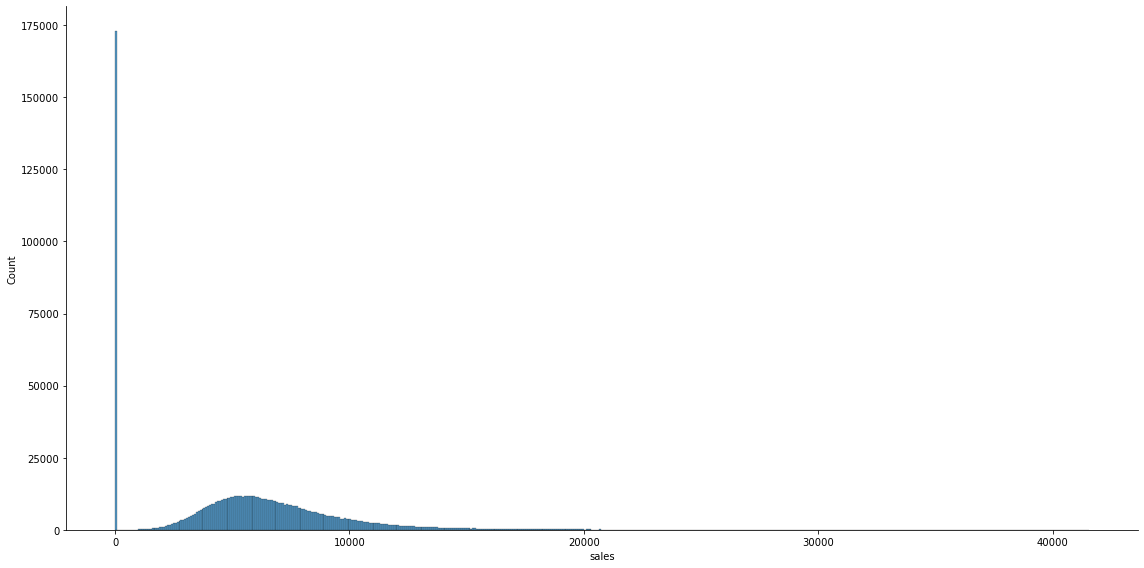

In [28]:
# Plotando as sales passando as colunas que quero mostrar
# Obs: Você consegue mudar o tamanho do plot usando os parâmetros height e aspect. Um exemplo ficaria assim:
# sns.displot(df1['sales'], height=8, aspect=2)
# Descobri isso procurando a função displot direto na documentação do seaborn: https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot
sns.displot( df1["sales"], height=8, aspect=2)

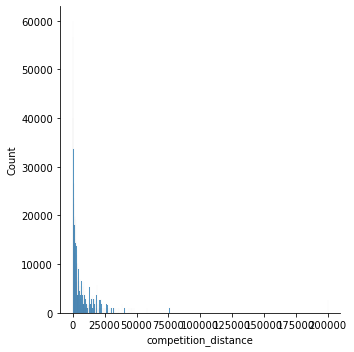

In [29]:
# Skew alta, alta concentração de valores no começo
# Meus competidores estão muito proximos

sns.displot( df1["competition_distance"])

## 1.7.2 Categorical Attributes

### Vai de boxblot!

In [30]:
# ??? No do Meigarom só apareceu os: state_holiday, store_type, assortment, promo_interval e month_map
# Tirei os int32 tambem dos categoricos
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

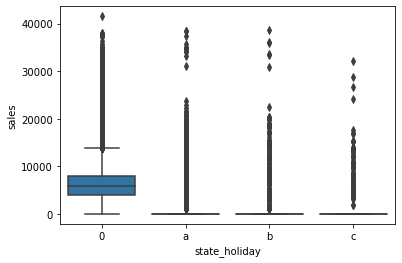

In [31]:
# Meigarom prefere o seaborn do que o matplotlib
# sns.boxplot( x= y=, data= )
# x = linha que vai ficar como referencia
# y = o que quero medir (no caso, as vendas)

sns.boxplot( x="state_holiday", y="sales", data=df1 )

<AxesSubplot:xlabel='assortment', ylabel='sales'>

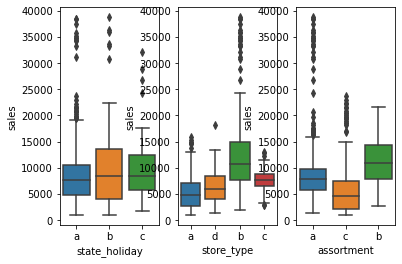

In [32]:
# Se plotamos da forma acima não da pra ver nada... (variaveis com ranges mt diferentes)
# Vamos filtrar os dados para plotar:
# ??? Pq esse 0 é uma string e nao um numero? df1["state_holiday"] != "0"

aux1 = df1[(df1["state_holiday"] != "0") & (df1["sales"] > 0)]

# plt.subplot = para plotar um do lado do outro

plt.pyplot.subplot( 1, 3, 1)
sns.boxplot( x="state_holiday", y="sales", data=aux1)

plt.pyplot.subplot( 1, 3, 2)
sns.boxplot( x="store_type", y="sales", data=aux1)

plt.pyplot.subplot( 1, 3, 3)
sns.boxplot( x="assortment", y="sales", data=aux1)

# Boxplot:
# Linha do meio é a mediana: chegou na metade dos valores (em termos de posição), aquele valor é sua mediana
# Limite inferior da barra: 25º quartil (quartil 25) e o limite superior é o quartil 75
# Os ultimos tracinhos são em cima o maximo e embaixo o minimo. Todos os pontos acima do tracinho de maximo são considerados outliers (3x o desvio padrão)
# assortment = mix de produtos

# 2.0. STEP 02 - FEATURE ENGINEERING

Para quê fazer a Feature Engineering? Para ter as variáveis DISPONÍVEIS para ESTUDO durante a Análise Exploratória dos Dados. Pra não ter bagunça, crie as variáveis ANTES na análise exploratória!!!

Vou usar uma classe Image para colocar a imagem do mapa mental:

In [33]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map 

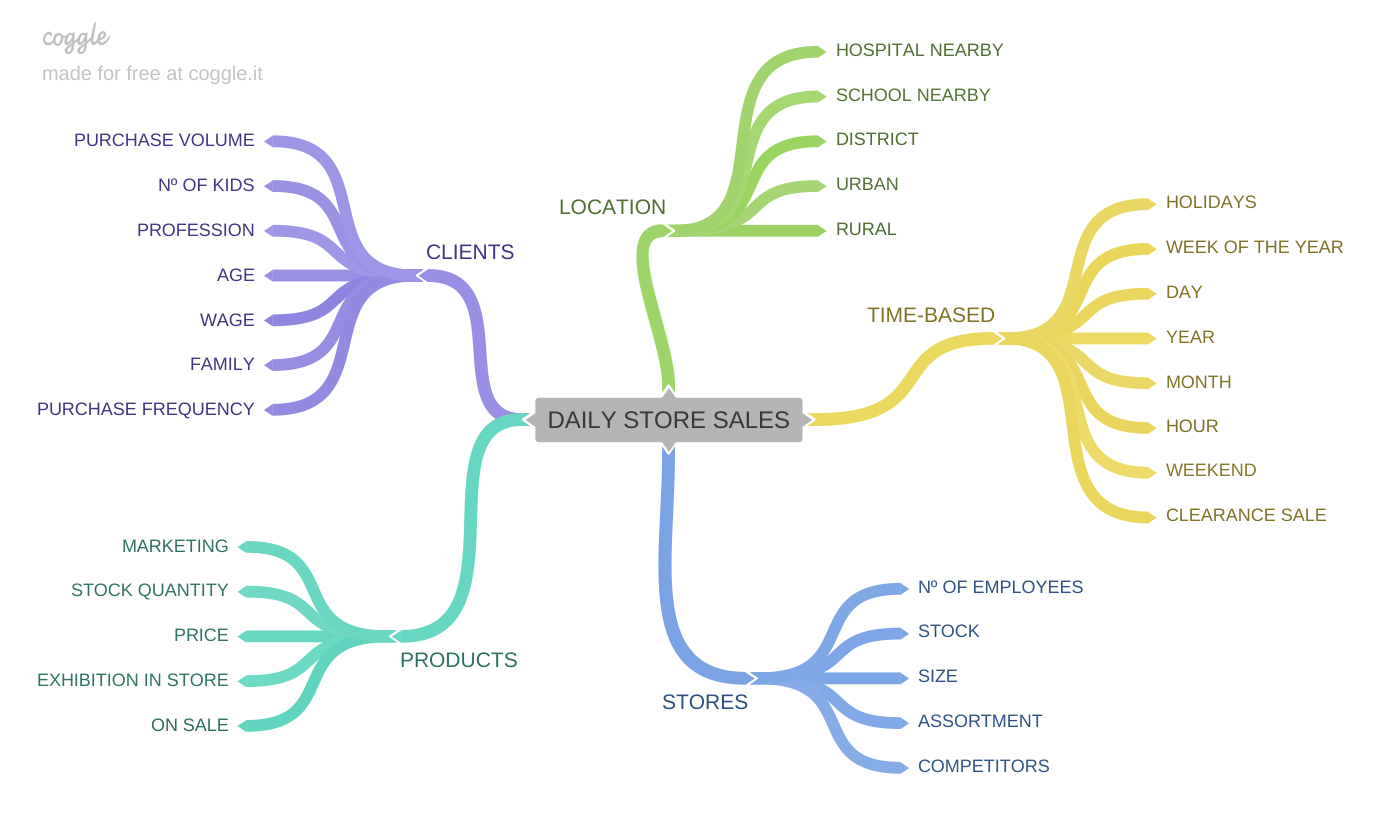

In [34]:
Image ("img/mind-map-hypothesis.png")

## 2.2. Hypothesis Creation

### 2.2.1 Store Hypothesis

1. Stores with greater number of employees should sell more.

2. Stores with greater stock size should sell more.

3. Stores with bigger size should sell more.

4. Stores with smaller size should sell less.

5. Stores with greater assortment should sell more.

6. Stores with more competitors nearby should sell less.

7. Stores with competitors for longer should sell more. 

### 2.2.2 Product Hypothesis

1. Stores with more marketing should sell more.

2. Stores that exhibit more products in the showcase sell more.

3. Stores that have lower prices on products should sell more.

4. Stores that have lower prices for longer on products should sell more.

5. Stores with more consecutive sales should sell more.

### 2.2.3Time-based Hypothesis

1. Stores with more days in holidays should sell less.

2. Stores that open in the first 6 months should sell more.

3. Stores that open on weekends should sell more.

## 2.3. Final Hypothesis List

### As hipóteses das quais temos os dados, vão para a lista final de hipóteses.



1. Stores with greater assortment should sell more.

2. Stores with more competitors nearby should sell less.

3. Stores with competitors for longer should sell more. 

4. Stores with active sales for longer should sell more.

5. Stores with more days on sale should sell more.

7. Stores with more consecutive sales should sell more.

8. Stores opened during the Christmas holiday should sell more.

9. Stores should sell more over the years.

10. Stores should sell more in the second half of the year.

11. Stores should sell more after the 10th of each month.

12. Stores should sell less on weekends.

13. Stores should sell less during school holidays. 

## 2.4. Feature Engineering

In [35]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
# aqui não usaremos nenhum metodo, e sim mudaremos a formatação da data apenas
# ele fala do strftime no bônus
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# week of year 
# ps: <ipython-input-35-d06c5b7375c4>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
#  df2["week_of_year"] = df2["date"].dt.weekofyear

# df2["week_of_year"] = df2["date"].dt.isocalendar().week
# year week 
# df2["year_week"] = df2["date"].dt.strftime("%Y-%W")

# competition since
# ja temos a coluna "date" para comparar, mas a informação de competition since está quebrada, temos coluna 
# com year e outra com month
# Precisamos juntar as duas em uma data e fazer a substração das duas
# método datetime vem de uma classe também chamada datetime
# datetime.datetime( year=, month=, day= )

# datetime.datetime( year= df2["competition_open_since_year"], month= df2["competition_open_since_month"], day= 1 )
# Vamos usar a função acima para todas as linhas do dataframe vamos usar lambda com variavel x e depois usar 
# o apply
# day = 1 pois nao temos informação sobre o dia
# o apply vai precisar do axis pois estou usando duas colunas diferentes

# df2["competition_since"] = df2.apply(lambda x: datetime.datetime( year= x["competition_open_since_year"], 
# month= x["competition_open_since_month"], day= 1), axis=1 )
# com esse comando acima geramos a coluna "competition_since" no formato 2008-09-01 00:00:00. Agora precisamos ver a diferença dessa data com a date para saber o tempo 

# df2['date'] - df2['competition_since'] )/30   
# divido por 30 pq quero manter a glanularidade em dias 
# o .days vai extrair os dias desse datetime e salva como inteiro em uma nova coluna 'competition_time_month'
# df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
# Para as promoçoes temos uma dificuldade a mais pois temos a coluna promo2 e informação de ano e semana
# não temos de mês
# Vamos fazer um join dos caracteres e depois converter na data
# Mas para juntar as variáveis assim precisamos que as 2 sejam strings (astype converte)
# colocamos o "-" pra ficar no formato ano - semana do ano

# df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# "promo_since" agora e string, nao é datetime

# Deu uma complicada nesse promo, mas bora lá...
#Truque para converter para data: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ). strptime( o que vai 
# mostrar, "formato")
# x pq vamos aplicar para todas as linhas do dataframe
# /7 para ter em semanas

# df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
# df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment (describes an assortment level: a = basic, b = extra, c = extended)
# Mudar as letras para o que isso representa pra ficar mais facil a leitura:
# Pq else e não elif na estrutura dentro do lambda???
# ??? object type é tipo string?
# Nao preciso usar o axis pq só vou usar a coluna "assortment"

# assortment
# df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# Mesma coisa do assortment no "state holiday"
# state holiday
# df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [36]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [37]:
# competition since, essa nova coluna vai pegar informaçao de duas colunas diferentes, 
# usando o datetime para definir e padronizando o dia como 1 ja que nao temos informaçao dos dias
# o axis é usando para o apply
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )

In [38]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [39]:
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

In [40]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [41]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# nesse momento o 'promo_since' é um string
# No bônus ele mostra mais detalhes sobre esse truque abaixo:
# df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%y-%W-%w' ) - datetime.timedelta( days=7 ) )
# df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
# df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
# df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0. STEP 03 - VARIABLES FILTERING

In [42]:
# Antes de qualquer coisa, ao começar um novo passo, copia o dataset do passo anterior e passa a trabalhar com um novo
df3 = df2.copy()

In [43]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,31-31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,Jul,1,2015,7,31,31,2015-30,2007-11-01,94,13-13
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,Jul,1,2015,7,31,31,2015-30,2006-12-01,105,14-14
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,31-31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,31-31


## 3.1. Rows Filtering

In [44]:
# "open" != 0 & "sales" > 0

df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

## 3.2. Columns Selection

In [45]:
# Vamos "dropar" as colunas que não queremos
# A "open" está aqui pois após tirarmos as linhas cujos dados da coluna "open" eram 0, só sobraram valores 1, então é uma coluna 'inútil'
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
# Drop é um metodo da classe Pandas (quais colunas e sentido); axis 0 = linhas, axis 1 = colunas
df3 = df3.drop( cols_drop, axis=1 )


In [46]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since'],
      dtype='object')

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS

In [47]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1 Response Variable

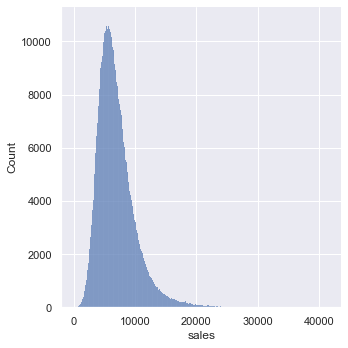

In [60]:
# Plotando a distribuição da variável resposta

sns.displot(df4["sales"])

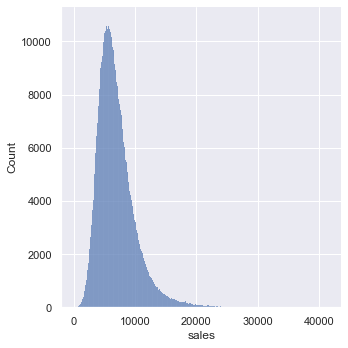

In [61]:
sns.displot( df4['sales'], kde=False )
# ??? Ficou sem diferença do plot anterior. Verificar

### 4.1.2 Numerical Variables

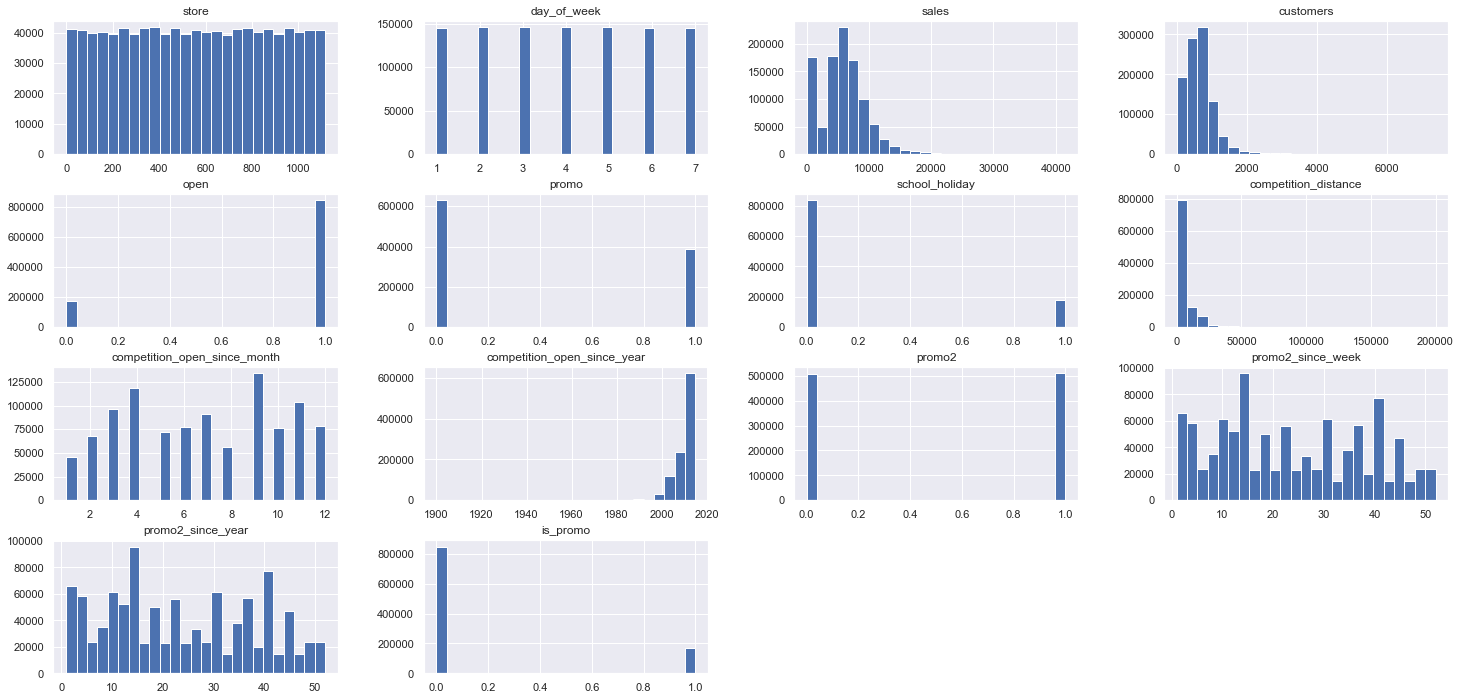

In [62]:
num_attributes.hist( bins=25 );
# kkkk ops
# os gráficos ficavam muito pequenos, mas usar a 'helper functions' do Meigarom solucionou

### 4.1.3 Categorical Variables

C:\Users\Luana\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Luana\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Luana\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

<AxesSubplot:>

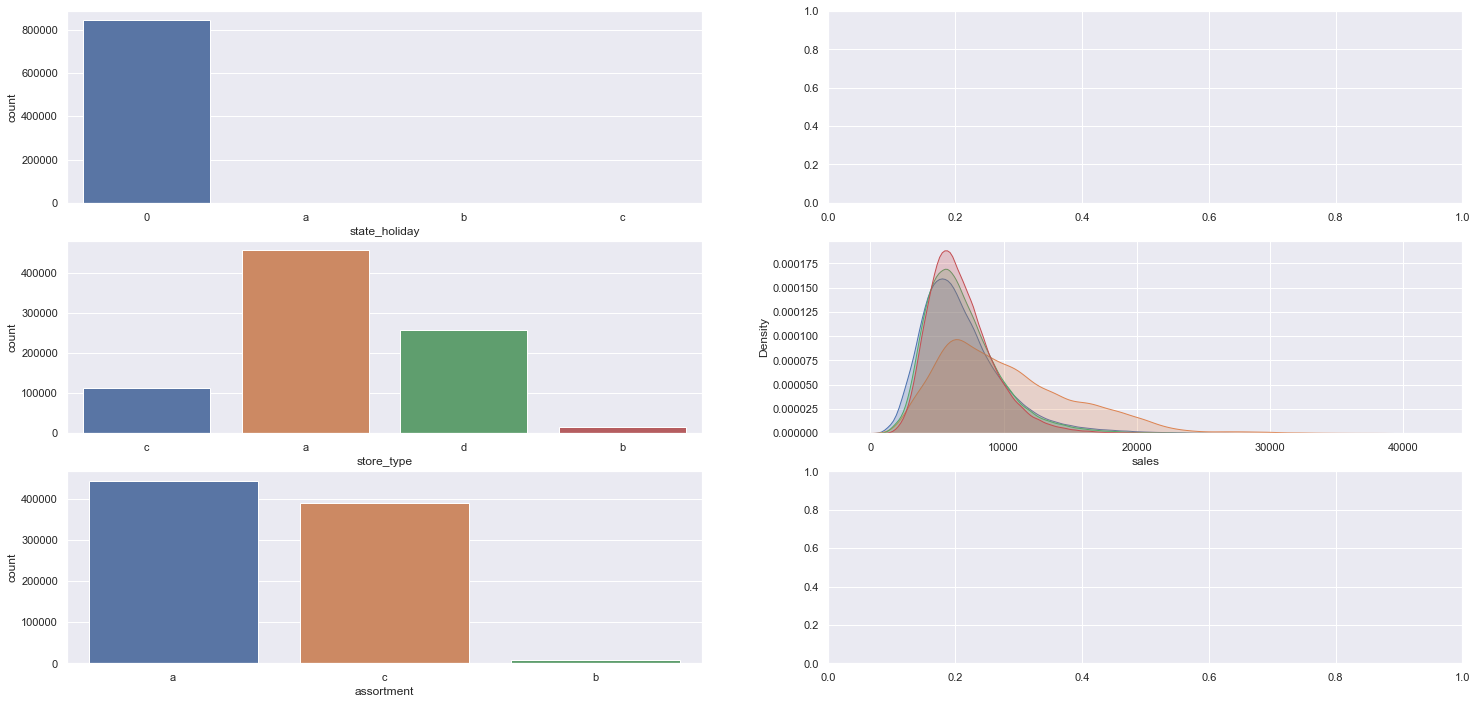

In [63]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 ) #row, column, position
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2. Bivariate Analysis

### H.1 Stores with greater assortment should sell more.

TypeError: no numeric data to plot

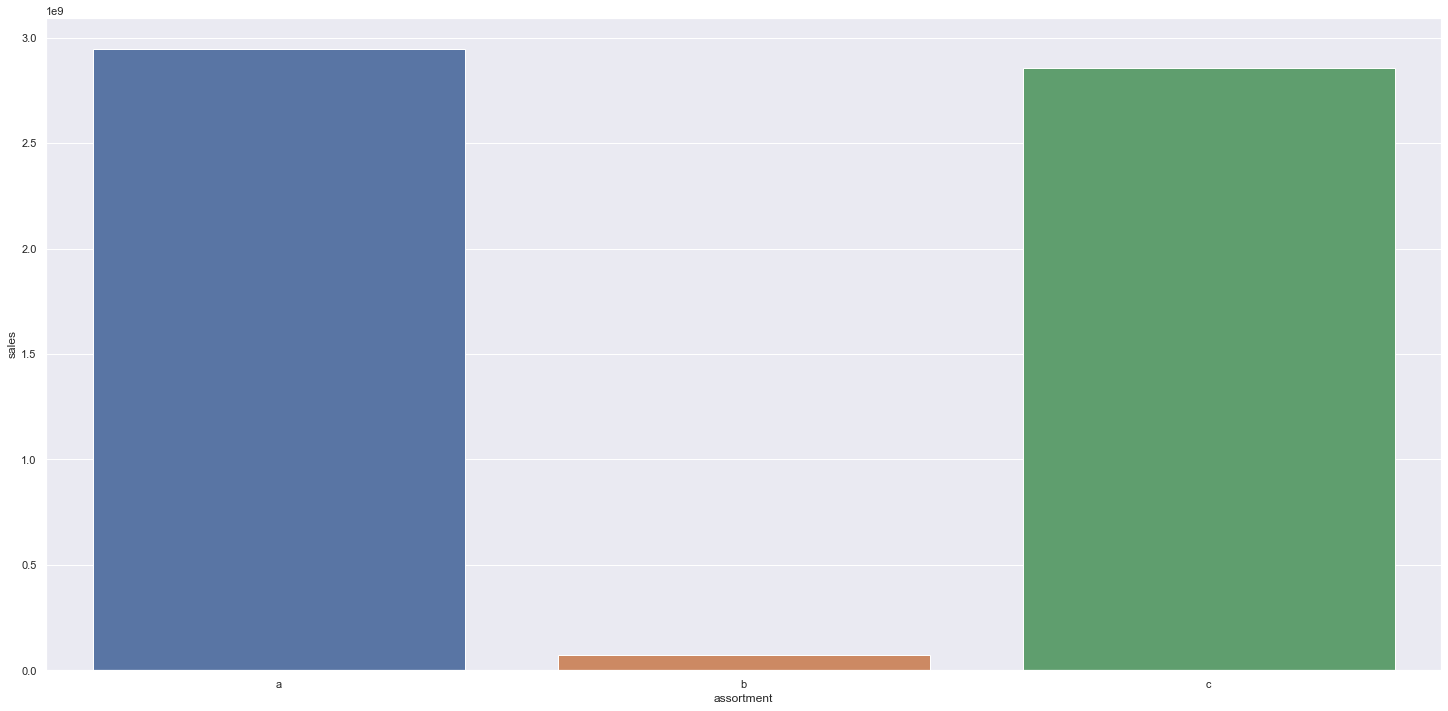

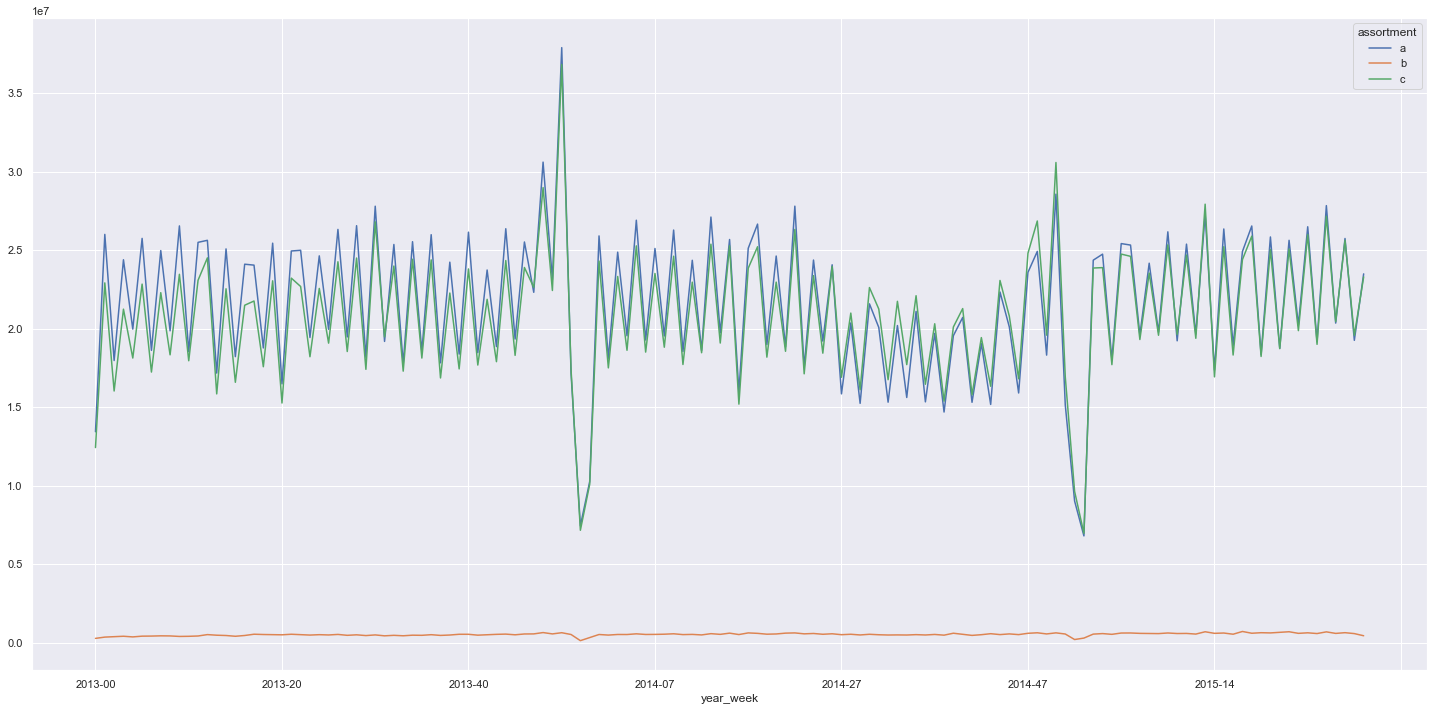

In [64]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H.2 Stores with more competitors nearby should sell less.

### H.3 Stores with competitors for longer should sell more.

## 4.1. Multivariate Analysis